<a href="https://www.kaggle.com/code/tejasurya/lgbm-xgb-catboost-cv-age-predict-regression?scriptVersionId=132420626" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Crab Age prediction using Ensemble models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as xgbr
from catboost import CatBoostRegressor as cbr
from lightgbm import LGBMRegressor as lgbmr

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")


In [2]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')
sample_df = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
for col in df.columns:
    print(col,end=",")
print(' are the columns in the Crab age dataset')

id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age, are the columns in the Crab age dataset


`Age`  is the target variable and rest of them are the predictors.

In [5]:
df.shape

(74051, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [7]:
df['Sex'].unique()

array(['I', 'M', 'F'], dtype=object)

Using Label encoder to handle the Categorical variable `Sex`.

In [8]:
label_encoder = LabelEncoder()
  
# Encode labels in column 'species'.
df['Sex']= label_encoder.fit_transform(df['Sex'])
  
df['Sex'].unique()

array([1, 2, 0])

In [9]:
df.describe()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.055016,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.820647,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,0.000000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,2.000000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [10]:
df.drop(columns='id',inplace=True)

# Any Missing data to handle ?

In [11]:
df.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

No missing data found.

# Finding the Correlation between the features

<Axes: >

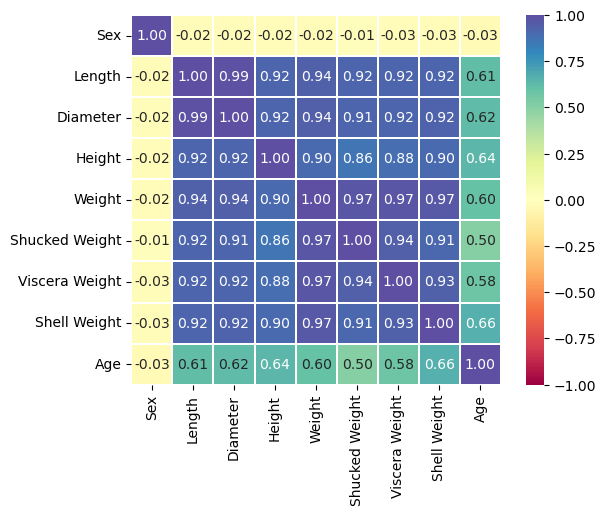

In [12]:
correlation = df.corr()
# creating a colormap
colormap = sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(correlation,annot=True,fmt='.2f',cmap=colormap,linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True)

From the Heatmap we can observe that,
* Weight and Shell weight are highly correlated features to each other.
* Similarly Length, Height and Diameter are correlated features to each other.
* All the numerical features are highly correlated to one another.

In [13]:
x = df.drop(columns=['Age']).copy()
y = df['Age'].copy()

Converting `Sex` category using label encoding in Test Data.

In [14]:
test_df.drop('id',axis=1,inplace=True)
test_df['Sex'] = label_encoder.fit_transform(test_df['Sex'])
test_df.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,1,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,0,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,0,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,1,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


# SPLIT DATA

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1,random_state=42)

In [16]:
results = pd.DataFrame({'name':[],'training_mae':[],'testing_mae':[],'best_parameters':[]})

In [17]:
iterations = 10000

# Model

# Lightgbm

In [18]:
lgb = lgbmr()

In [19]:
def regression_metrics(y_test,y_pred):
    print("MAE:\t",round(mae(y_test,y_pred),4))
    return round(mae(y_test,y_pred),4)

In [20]:
def model_evaluate(model, param_grid, x_train, y_train, x_test,y_test, model_name, k_folds=4, scoring='neg_mean_absolute_error', fit_parameters={}):
    model_cv = GridSearchCV(model, param_grid, cv=k_folds, verbose=False, scoring= scoring)
    model_cv.fit(x_train, y_train, **fit_parameters)
    y_train_pred = model_cv.predict(x_train)
    y_test_pred = model_cv.predict(x_test)

    print('Mean Absolute Error = ', np.abs(model_cv.score(x_train, y_train)))
    print("Training metrics:")
    training_mae = regression_metrics(y_train ,y_train_pred)
    print("\nTesting metrics:")
    testing_mae = regression_metrics(y_test ,y_test_pred)
    
    print('best parameters')
    print (model_cv.best_params_)
    ytest = model_cv.predict(x_test)
    
    results['name']=model_name
    results['training_mae'] = training_mae
    results['testing_mae'] = testing_mae
    results['best_parameters'] = model_cv.best_params_
    
    return model_cv

In [21]:
parameters = {
     'boosting': ['gbdt' ],
     'objective': ['regression_l1'],
    'metric': ['mae'],
     'num_iterations': [iterations],
     'learning_rate':[0.03],
     'subsample':[0.4],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
     'min_data_in_leaf':[256],
     'feature_fraction': [0.3],
     'num_leaves':[255],
     'max_depth':[8],
     'random_state':[28],
    }


In [22]:
model_lgb = model_evaluate(lgb, parameters, x_train, y_train, x_test, y_test, 'LGBM',
                           fit_parameters={'eval_set':[(x_val, y_val)],
                                           'early_stopping_rounds':300,'verbose':500,'eval_metric':'mae'})

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=256, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=256
[500]	valid_0's l1: 1.38091
[1000]	valid_0's l1: 1.37745
[1500]	valid_0's l1: 1.37621
[2000]	valid_0's l1: 1.37526
[2500]	valid_0's l1: 1.37465
[3000]	valid_0's l1: 1.37427
[3500]	valid_0's l1: 1.37383
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=256, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=256
[500]	valid_0's l1: 1.37985
[1000]	valid_0's l1: 1.37675
[1500]	valid_0's l1: 1.37559


In [23]:
lgb_pred= model_lgb.predict(test_df)
lgb_pred

array([ 6.9492991 ,  7.86794875, 10.38358859, ..., 12.9384546 ,
        9.23660518, 11.92196547])

In [24]:
import math
def round_off(x):
    return round(x)

In [25]:
lgb_pred = list(map(round_off,lgb_pred))

In [26]:
submission_lgb = pd.DataFrame({'id': sample_df.id, 'Age': lgb_pred})
submission_lgb.to_csv(path_or_buf = 'submission_lgb.csv', index = False)
pd.read_csv('submission_lgb.csv')

,id,Age
0,74051,7
1,74052,8
2,74053,10
3,74054,10
4,74055,7
...,...,...
49363,123414,10
49364,123415,8
49365,123416,13
49366,123417,9


# XGBOOST

In [27]:
xgb = xgbr()

In [28]:
xgb_parameters = {
    'booster':['gbtree'],
    'tree_method':['hist'],
        'gamma': [0.5],
        'reg_alpha' : [1.25],
        'eta':[0.03],
        'reg_lambda' : [0.00001],
        'colsample_bytree' : [0.75],
        'min_child_weight' : [40],
        'n_estimators': [iterations//3],
        'seed': [42],
    'max_depth': [7],
    }

In [29]:
model_xgb = model_evaluate(xgb, xgb_parameters, x_train, y_train, x_test, y_test, 'XGBM',
                           fit_parameters={'eval_set':[(x_val, y_val)], 
                                           'early_stopping_rounds':100,'verbose':500,'eval_metric':'mae'})

[0]	validation_0-mae:9.17469
[206]	validation_0-mae:1.40585
[0]	validation_0-mae:9.17495
[205]	validation_0-mae:1.40388
[0]	validation_0-mae:9.17448
[206]	validation_0-mae:1.40796
[0]	validation_0-mae:9.17520
[209]	validation_0-mae:1.40197
[0]	validation_0-mae:9.17472
[206]	validation_0-mae:1.40274
Mean Absolute Error =  1.3364363965371244
Training metrics:
MAE:	 1.3364

Testing metrics:
MAE:	 1.3858
best parameters
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.03, 'gamma': 0.5, 'max_depth': 7, 'min_child_weight': 40, 'n_estimators': 3333, 'reg_alpha': 1.25, 'reg_lambda': 1e-05, 'seed': 42, 'tree_method': 'hist'}


In [30]:
xgb_pred= model_xgb.predict(test_df)
xgb_pred

array([ 7.3486347,  7.490506 , 10.5497675, ..., 12.491921 ,  9.413254 ,
       11.884831 ], dtype=float32)

In [31]:
xgb_pred = list(map(round_off,xgb_pred))

In [32]:
submission_xgb = pd.DataFrame({'id': sample_df.id, 'Age': xgb_pred})
submission_xgb.to_csv(path_or_buf = 'submission_xgb.csv', index = False)
pd.read_csv('submission_xgb.csv')

,id,Age
0,74051,7
1,74052,7
2,74053,11
3,74054,9
4,74055,7
...,...,...
49363,123414,10
49364,123415,8
49365,123416,12
49366,123417,9


# CATBOOST

In [33]:
cbr_parameters = {'loss_function': 'MAE','eval_metric': 'MAE','iterations': iterations,
    'l2_leaf_reg': 1.6,'min_data_in_leaf': 27,'learning_rate': 0.07,'od_wait': 40,'max_depth': 7,
    'random_strength': 0.6,'bagging_temperature' : 2.75,'colsample_bylevel': 0.8,'max_bin': 256 }

In [34]:
cb = cbr(**cbr_parameters)

In [35]:
cb.fit(x_train, y_train)

0:	learn: 2.2611145	total: 73.4ms	remaining: 12m 14s
1:	learn: 2.1939727	total: 88.3ms	remaining: 7m 21s
2:	learn: 2.1299783	total: 102ms	remaining: 5m 40s
3:	learn: 2.0728772	total: 116ms	remaining: 4m 50s
4:	learn: 2.0146914	total: 130ms	remaining: 4m 20s
5:	learn: 1.9611672	total: 143ms	remaining: 3m 58s
6:	learn: 1.9139145	total: 157ms	remaining: 3m 43s
7:	learn: 1.8719743	total: 168ms	remaining: 3m 29s
8:	learn: 1.8353684	total: 181ms	remaining: 3m 20s
9:	learn: 1.8021312	total: 193ms	remaining: 3m 13s
10:	learn: 1.7701616	total: 206ms	remaining: 3m 6s
11:	learn: 1.7408602	total: 218ms	remaining: 3m 1s
12:	learn: 1.7157774	total: 230ms	remaining: 2m 56s
13:	learn: 1.6912100	total: 243ms	remaining: 2m 53s
14:	learn: 1.6699455	total: 255ms	remaining: 2m 49s
15:	learn: 1.6509241	total: 267ms	remaining: 2m 46s
16:	learn: 1.6317466	total: 283ms	remaining: 2m 45s
17:	learn: 1.6157053	total: 295ms	remaining: 2m 43s
18:	learn: 1.5993849	total: 308ms	remaining: 2m 41s
19:	learn: 1.5846934	

In [36]:
y_train_pred = cb.predict(x_train)
y_test_pred = cb.predict(x_test)

In [37]:
print('Mean Absolute Error = ', np.abs(cb.score(x_train, y_train)))
print("Training metrics:")
regression_metrics(y_train ,y_train_pred)
print("\nTesting metrics:")
regression_metrics(y_test ,y_test_pred)

Mean Absolute Error =  0.6628160524171517
Training metrics:
MAE:	 1.1259

Testing metrics:
MAE:	 1.3748


1.3748

Observation:

After implementing CatBoost algorithm,
* Overfitting has occured since 
  Training data - Mean absolute error is 1.1259,
  Testing data  - MAE is 1.3748

In [38]:
cb_pred= cb.predict(test_df)
cb_pred

array([ 7.11592083,  7.93102564, 10.33020666, ..., 13.27550494,
        9.19076848, 11.25805563])

In [39]:
cb_pred = list(map(round_off,cb_pred))

In [40]:
submission_cb = pd.DataFrame({'id': sample_df.id, 'Age': cb_pred})
submission_cb.to_csv(path_or_buf = 'submission_cb.csv', index = False)
pd.read_csv('submission_cb.csv')

,id,Age
0,74051,7
1,74052,8
2,74053,10
3,74054,9
4,74055,7
...,...,...
49363,123414,10
49364,123415,8
49365,123416,13
49366,123417,9


# Model Results

In [41]:
print(results)

                  name  training_mae  testing_mae best_parameters
boosting          XGBM        1.3364       1.3858             NaN
feature_fraction  XGBM        1.3364       1.3858             NaN
learning_rate     XGBM        1.3364       1.3858             NaN
max_depth         XGBM        1.3364       1.3858               7
metric            XGBM        1.3364       1.3858             NaN
min_data_in_leaf  XGBM        1.3364       1.3858             NaN
num_iterations    XGBM        1.3364       1.3858             NaN
num_leaves        XGBM        1.3364       1.3858             NaN
objective         XGBM        1.3364       1.3858             NaN
random_state      XGBM        1.3364       1.3858             NaN
reg_alpha         XGBM        1.3364       1.3858            1.25
reg_lambda        XGBM        1.3364       1.3858         0.00001
subsample         XGBM        1.3364       1.3858             NaN


In [42]:
results.to_csv(path_or_buf = 'results.csv', index = False)